In [151]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Finance related operations
from pandas_datareader import data

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

## 1. Load Data

We are loading the every csv file separately from the Data folder in the project directory. Once we have stored them in our Notebook we merge them together to form a larger dataframe containing all the information we have available.

In [152]:
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv', index_col=0)
df_2015 = pd.read_csv('Data/2015_Financial_Data.csv', index_col=0)
df_2016 = pd.read_csv('Data/2016_Financial_Data.csv', index_col=0)
df_2017 = pd.read_csv('Data/2017_Financial_Data.csv', index_col=0)
df_2018 = pd.read_csv('Data/2018_Financial_Data.csv', index_col=0)

Now we add new YEAR column to each of the dataframes to later being able to group the rows by their year. We add them to an array, so we can iterate over them.

In [153]:
df_2014['year'] = '2014'
df_2015['year'] = '2015'
df_2016['year'] = '2016'
df_2017['year'] = '2017'
df_2018['year'] = '2018'

dataframes = [df_2014, df_2015, df_2016, df_2017, df_2018]

# 2. Merging of datasets

In [154]:
for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4120 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4797 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4960 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, CMCSA to ZYME
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 7.6+ MB
None


We can see that the datasets are quite similar. The only thing that varies between them is the number of rows. As we want to append all the datasets to form a bigger dataset we expect 3808 + 4120 + 4797 + 4960 + 4392 = 22'077 rows in the generated dataset.

Looking at the column data types we have:
- 222 numeric (financial indicators)
- 1 integer (the **class** column)
- 2 objects (**Sector and Price Change** column)

In order to be able to append all the dataframes together we have to make sure all the columns have the same naming. It looks like the only column that is named differently from all the others across the datasets is the price change column. We are renaming it to 'PRICE CHANGE [%]'.


In [155]:
year = 2015
for df in dataframes:
    df.rename(columns = {f'{year} PRICE VAR [%]': 'PRICE CHANGE [%]'}, inplace=True)
    year += 1

To check our assumption and see if now all the columns really are the same we use the numpy array_equal function.

In [156]:
columns_2014 = df_2014.columns.values.tolist()
columns_2015 = df_2015.columns.values.tolist()
columns_2016 = df_2016.columns.values.tolist()
columns_2017 = df_2017.columns.values.tolist()
columns_2018 = df_2018.columns.values.tolist()

print(f'Columns in df 2014 and 2015 are equal: {np.array_equal(columns_2014, columns_2015)}')
print(f'Columns in df 2015 and 2016 are equal: {np.array_equal(columns_2015, columns_2016)}')
print(f'Columns in df 2016 and 2017 are equal: {np.array_equal(columns_2016, columns_2017)}')
print(f'Columns in df 2017 and 2018 are equal: {np.array_equal(columns_2017, columns_2018)}')

Columns in df 2014 and 2015 are equal: True
Columns in df 2015 and 2016 are equal: True
Columns in df 2016 and 2017 are equal: True
Columns in df 2017 and 2018 are equal: True


As we see that all computations output TRUE. By reflexivity we know that the columns of all the datasets now have the same values. Now we can start appending them to form the mega-dataset we want to start working with.

In [157]:
df = pd.concat(dataframes)

As expected we get a new dataframe with 22'077 entries and the common number of columns (225) of the individual datasets.

# 3. Start cleaning
Now that we have some information at one place we can start cleaning the dataset.

## 3.1 Price Change outliers
As Price change is probably our most important feature we want to prepare that one first. This section is strongly inspired by an analysis done by Nicolas Carbone and can be found [HERE](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset)
We are looking for major peaks/valleys, which indicate stocks that increased/decreased in value by an incredible amount with respect to the overall sector.

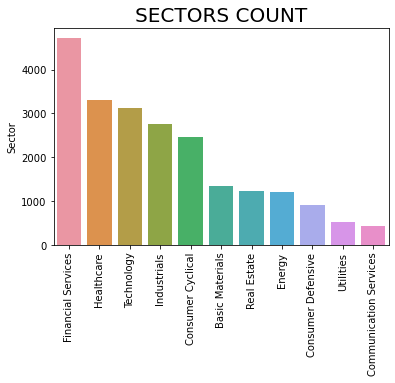

In [158]:
sectors = df['Sector'].unique().tolist()

df_sector = df['Sector'].value_counts()
sns.barplot(x=np.arange(len(df_sector)), y=df_sector)
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.title('SECTORS COUNT', fontsize=20)
plt.show()

As we see our dataset is unbalanced in regards to the sector count. This can lead to overfitting, but we will leave the data as is as it represents the true distribution of sectors in reality. Now let's take a look at a graphical representation of all the returns within a sector in the year 2019.

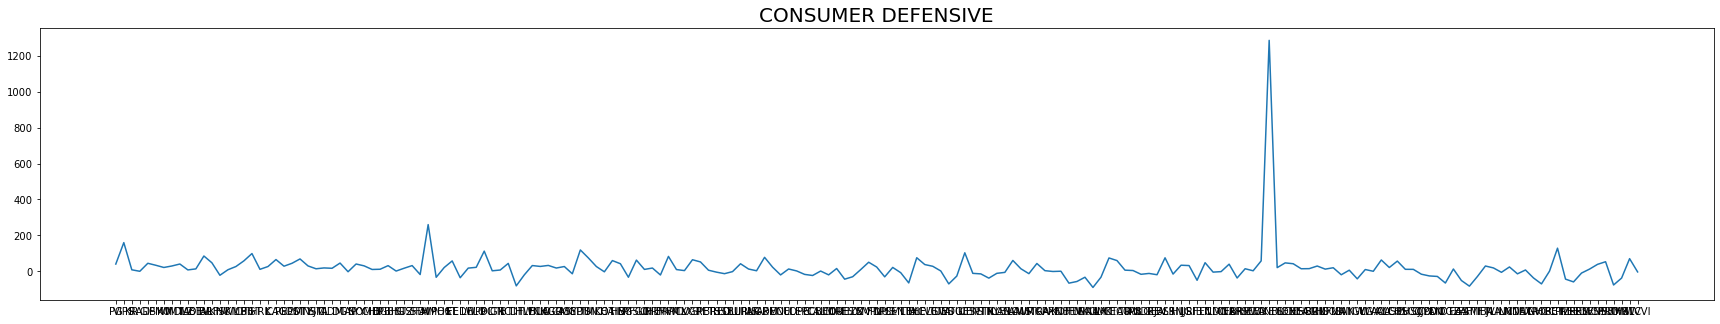

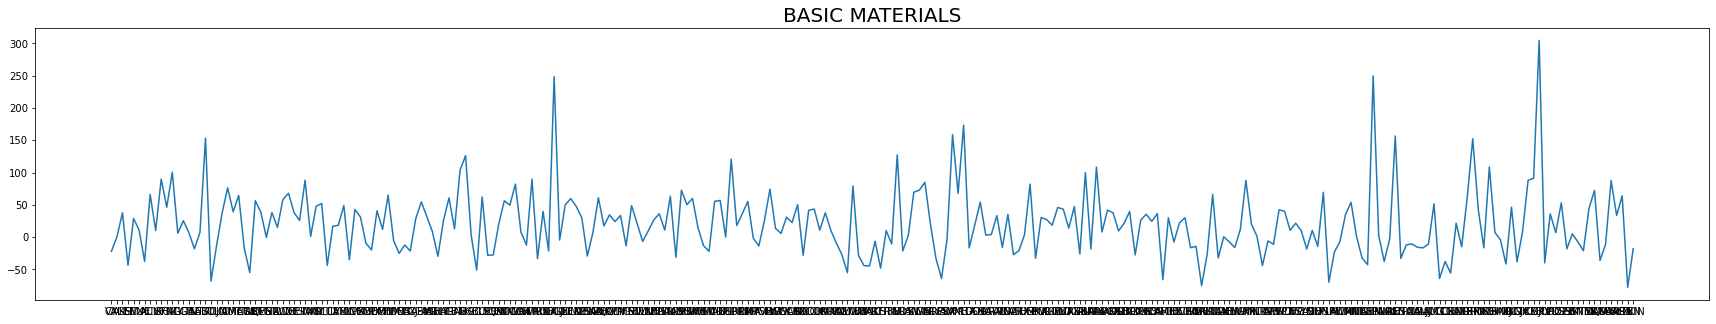

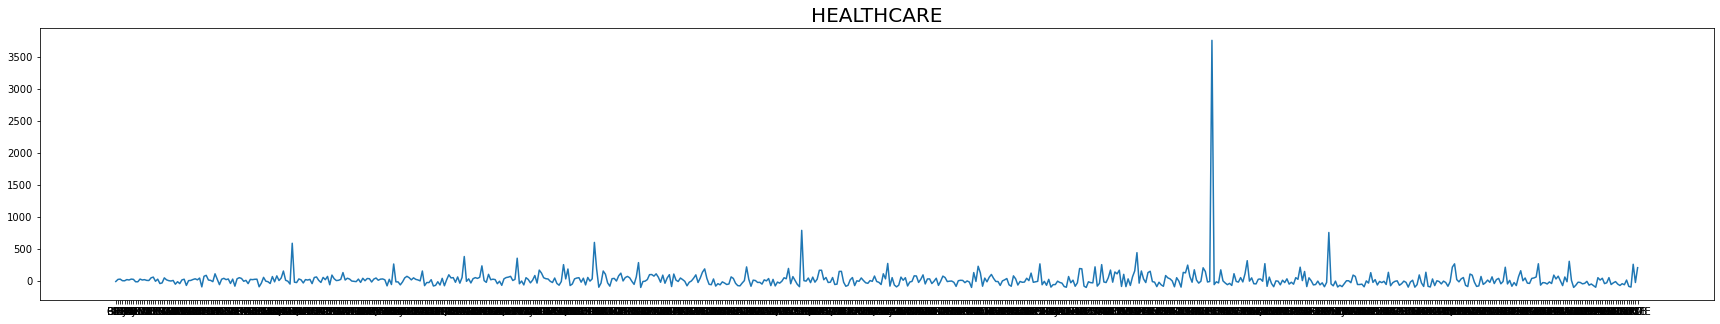

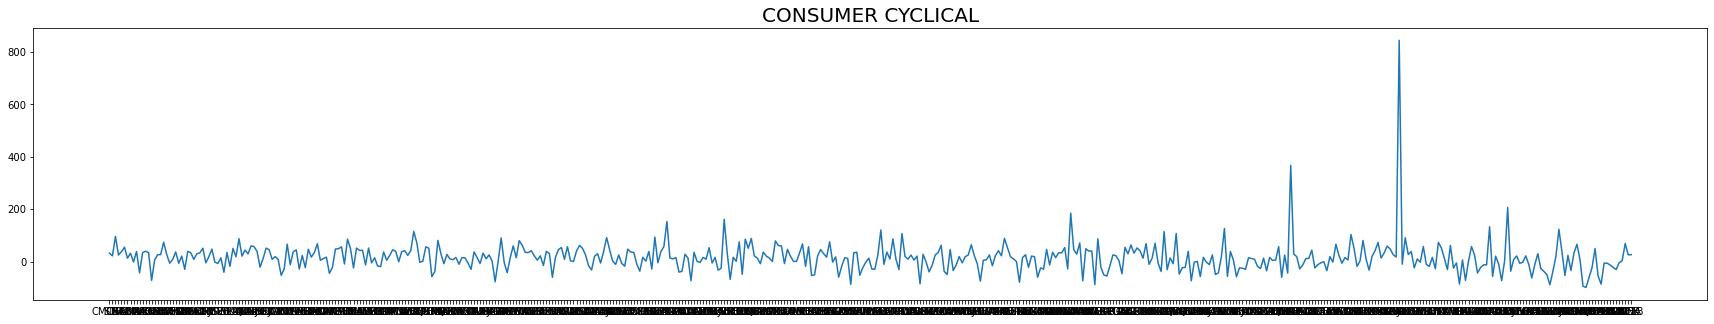

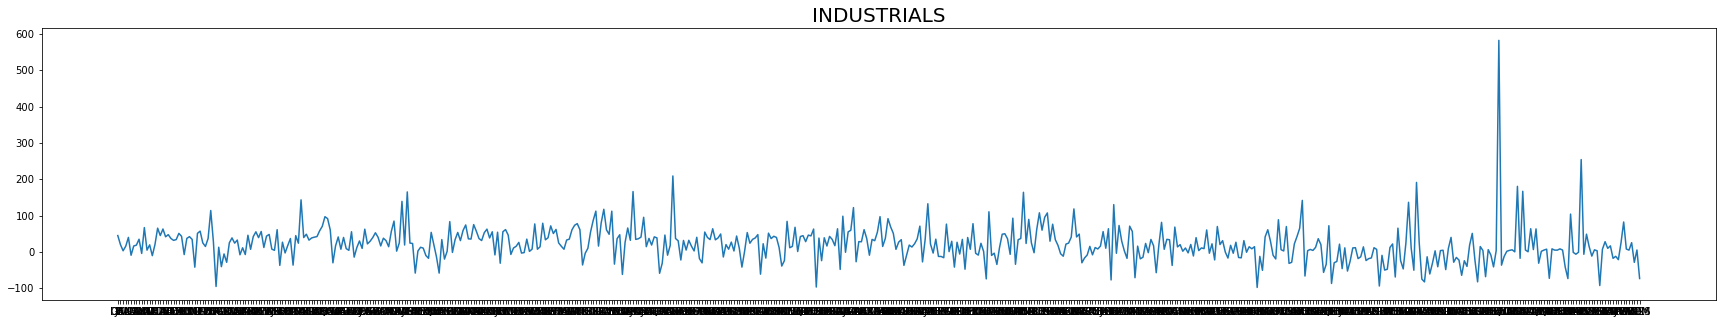

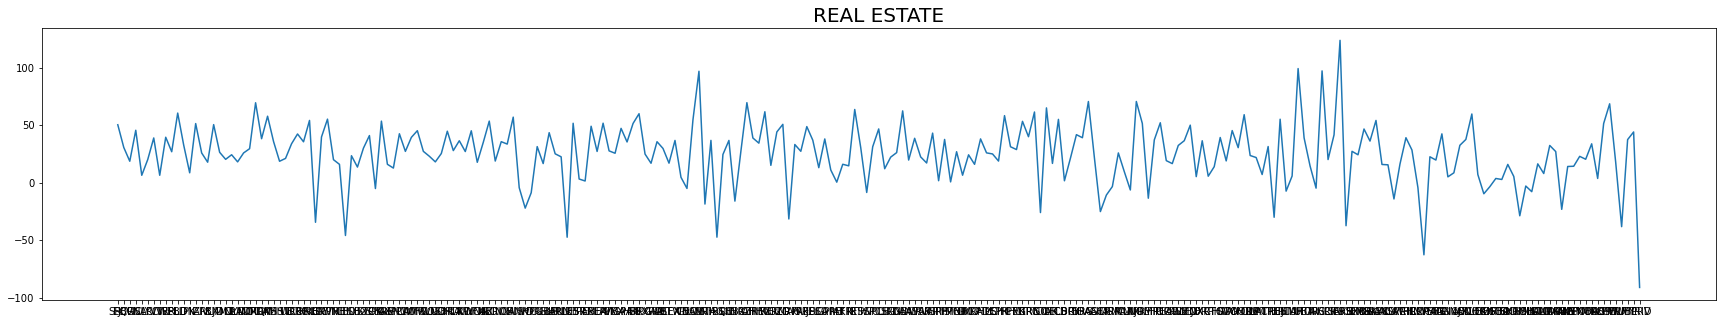

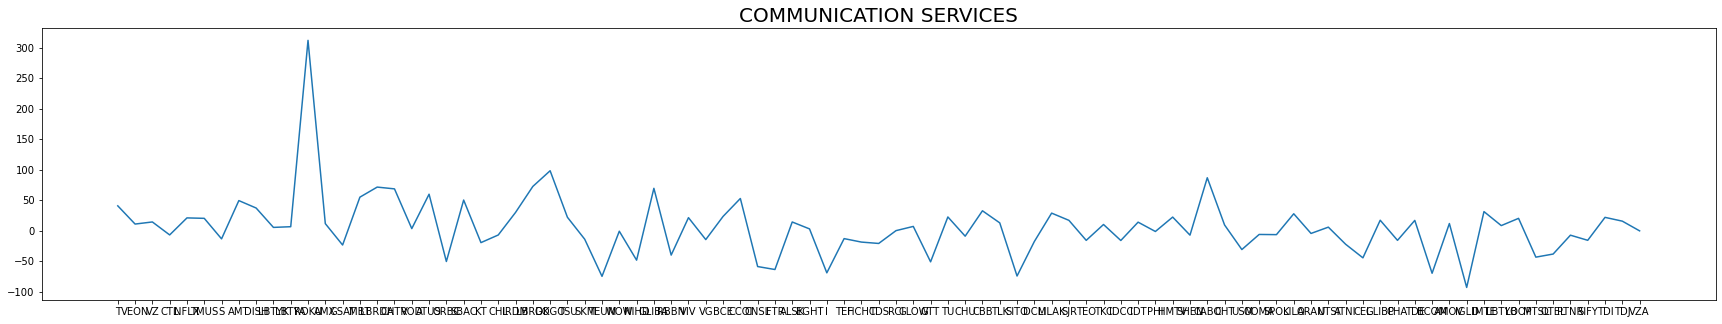

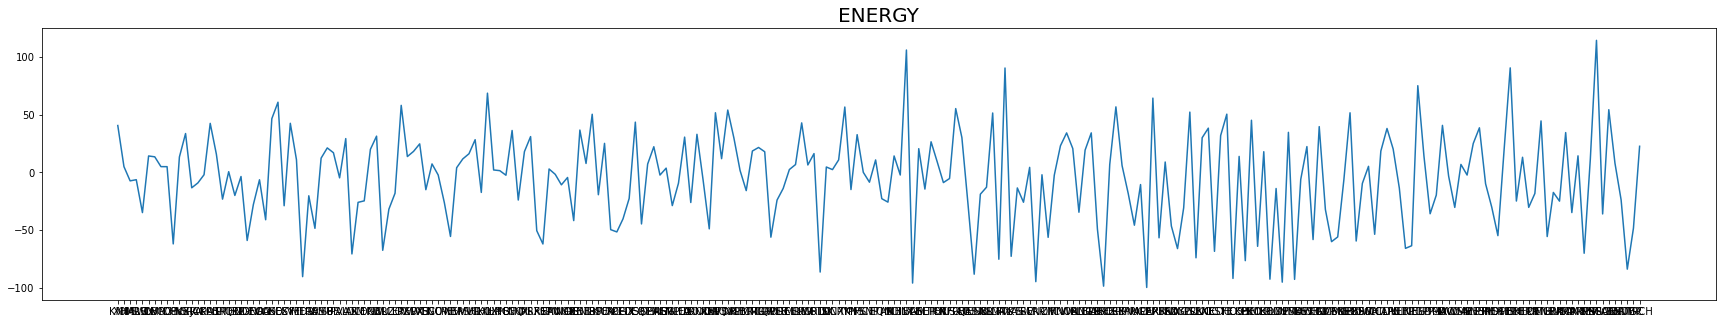

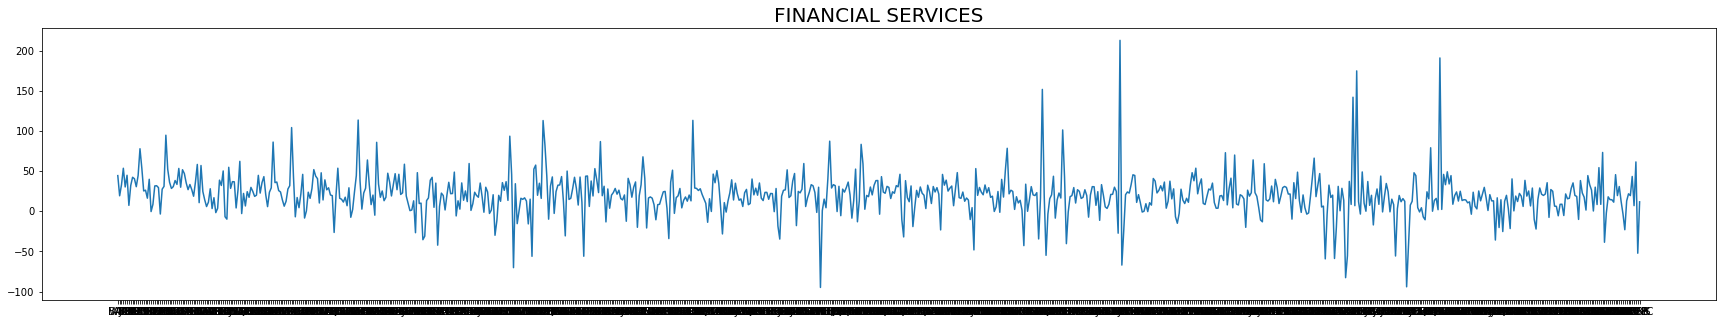

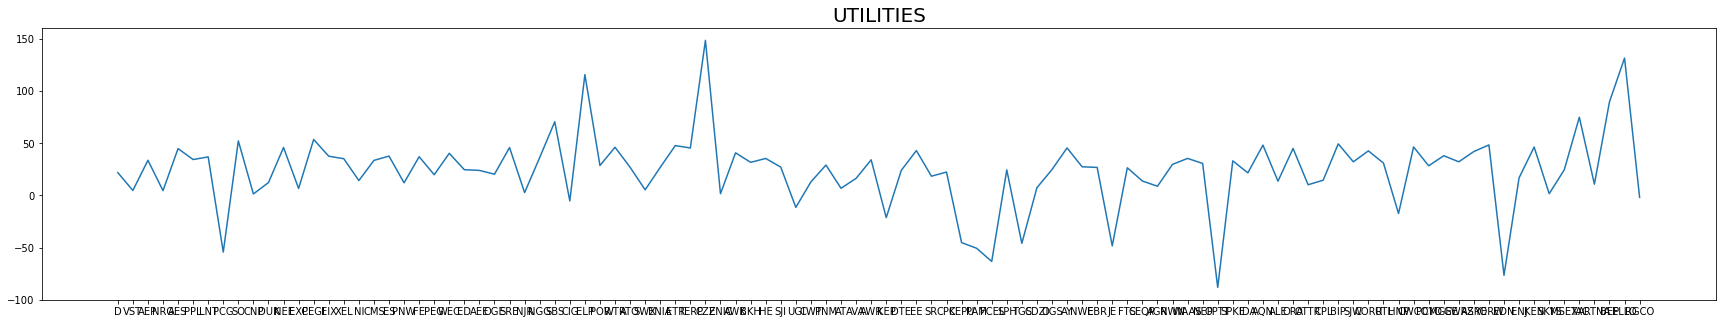

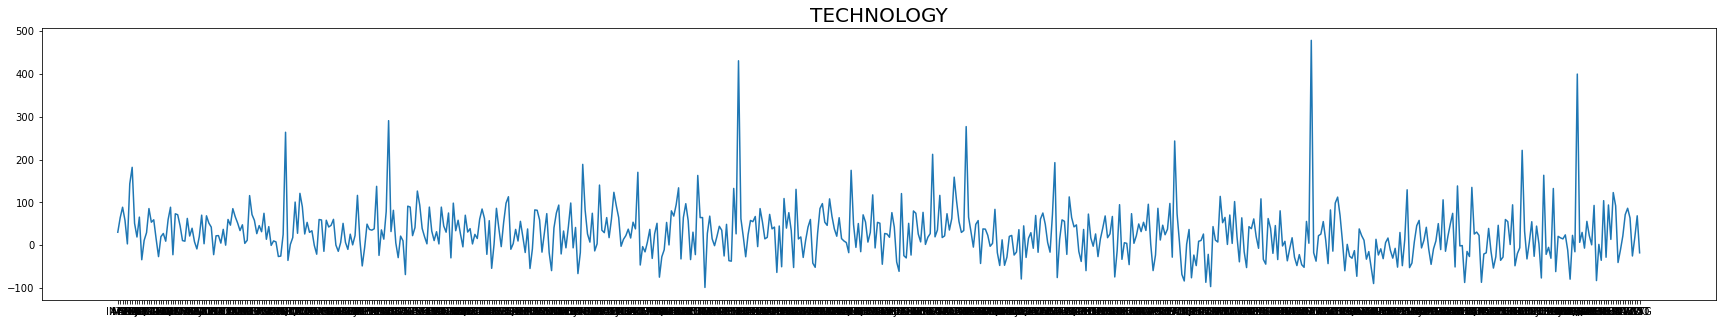

In [159]:
# Extract the columns we need in this step from the dataframe
df_ = df_2018.loc[:, ['Sector', 'PRICE CHANGE [%]']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Plot the percent price variation for each sector
for sector in sectors:

    temp = df_[df_['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp['PRICE CHANGE [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

As we see there is quite a number of peaks. We now want to dig a little deeper into that and examine wether those price changes could have been organic or inorganic growth. [Nicolas Carbone](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset) suggests to determine a threshhold, find all stocks that have performed better than the threshhold and get some financial data from Yahoo Finance for these specific stocks. More precisely we will compare the *Adjusted Daily Close Price* to the *Volume* and decide on that basis if it was organic or inorganic growth. We will do exactly that for every stock that had a performance greater that 500% in any year of our dataset.
Since the code for determining that in any year is mostly the same but only changes in some specific variables I will create a function that we will be able to reuse throughout the code.

In [160]:
def find_inorganic_stocks(df_, year, gain):
    inorganic_stocks = df_[df_['PRICE CHANGE [%]'] >= gain]
    top_gainers = inorganic_stocks['PRICE CHANGE [%]'].sort_values(ascending=False)
    print(f'{len(inorganic_stocks)} STOCKS with more than {gain}% gain.')
    print()

    # Set
    date_start = f'01-01-{year}'
    date_end = f'12-31-{year}'
    tickers = top_gainers.index.values.tolist()

    for ticker in tickers:

        try:
            # Get daily prices for that stock from Yahoo finance
            daily_price = data.DataReader(ticker, 'yahoo', date_start, date_end)

            # Plot prices with volume
            fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

            ax0.plot(daily_price['Adj Close'])
            ax0.set_title(ticker, fontsize=18)
            ax0.set_ylabel('Daily Adj Close $', fontsize=14)
            ax1.plot(daily_price['Volume'])
            ax1.set_ylabel('Volume', fontsize=14)
            ax1.yaxis.set_major_formatter(
                    matplotlib.ticker.StrMethodFormatter('{x:.0E}'))

            fig.align_ylabels(ax1)
            fig.tight_layout()
            plt.show()

        except Exception as e:
            print(e)

    return tickers


### 3.1.1 Price Changes >500% in 2014

22 STOCKS with more than 500% gain.



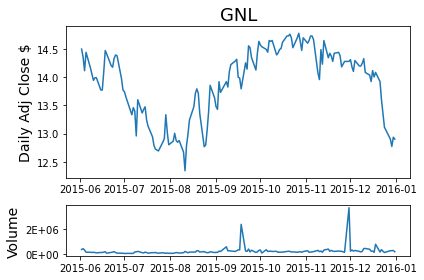

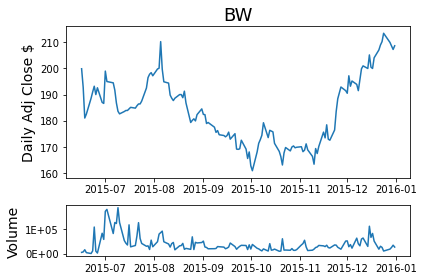

No data fetched for symbol NK using YahooDailyReader
No data fetched for symbol PUB using YahooDailyReader


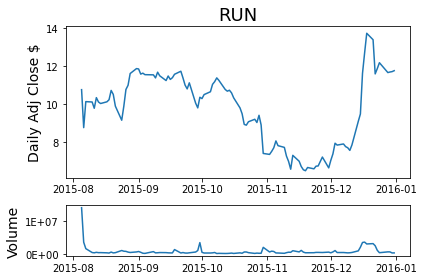

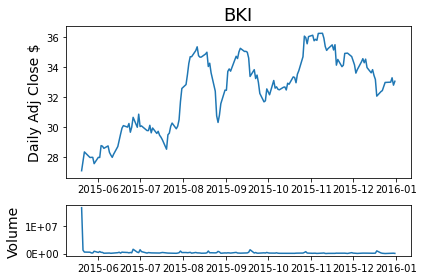

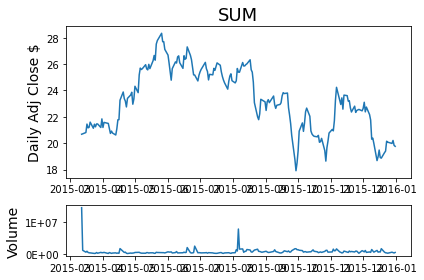

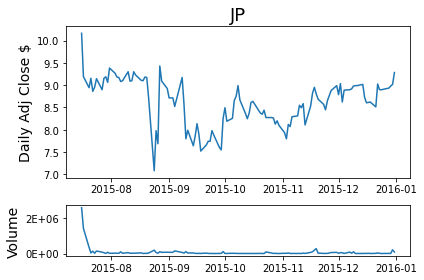

No data fetched for symbol JAX using YahooDailyReader


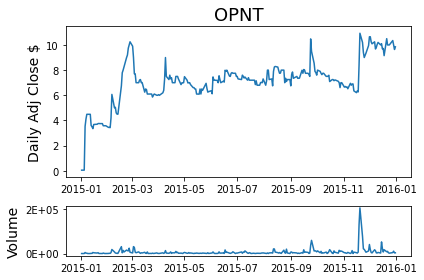

No data fetched for symbol AMRH using YahooDailyReader


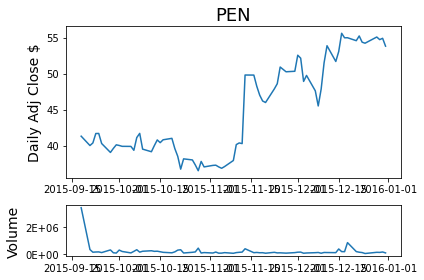

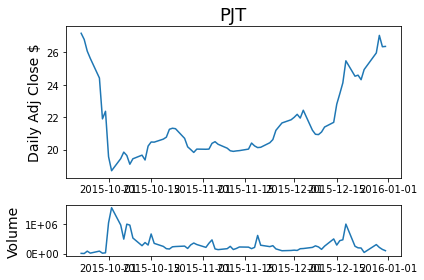

No data fetched for symbol FSB using YahooDailyReader


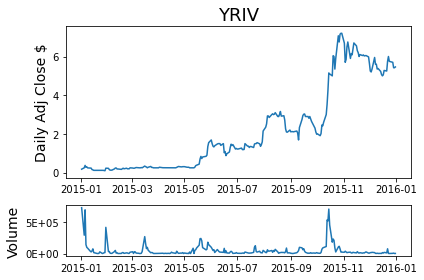

No data fetched for symbol LBCC using YahooDailyReader


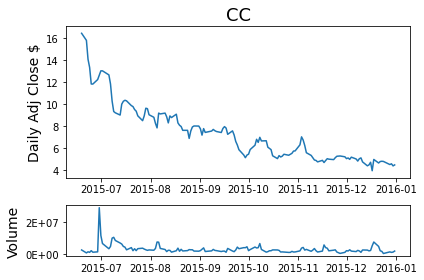

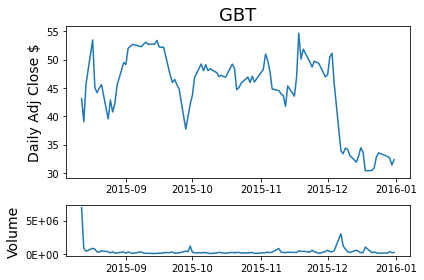

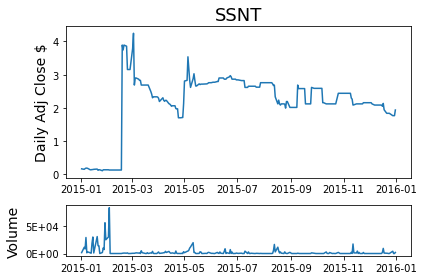

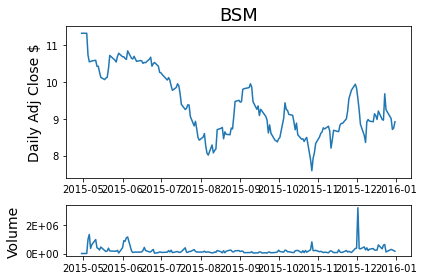

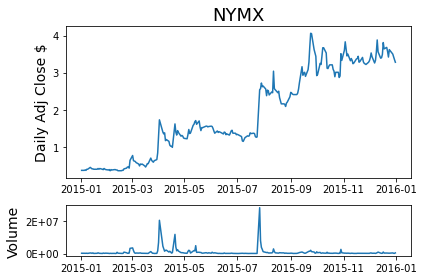

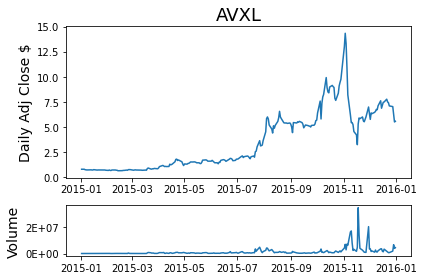

In [161]:
high_gainers_2014 = find_inorganic_stocks(df_2014, 2015, 500)

Looking at these plots we have a lot of flat trading volume, very massive spikes and data that is not available for the entire year. For these cases we assume that these stocks did not grow organically. So we end up only taking *NYMX* and *AVXL* as organic growth. Therefore we exclude them from the high_gainers_2014 and drop those stocks then from the 2014 dataset.

In [162]:
high_gainers_2014.remove('NYMX')
high_gainers_2014.remove('AVXL')
df_2014.drop(high_gainers_2014, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2015

10 STOCKS with more than 500% gain.

No data fetched for symbol ARA using YahooDailyReader
No data fetched for symbol LN using YahooDailyReader


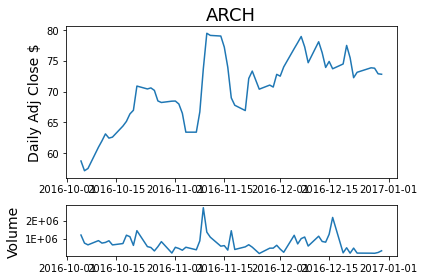

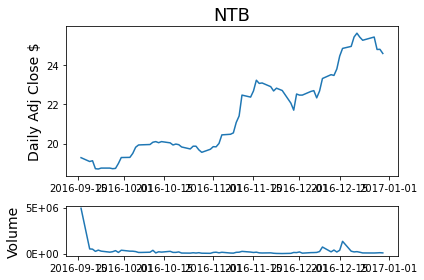

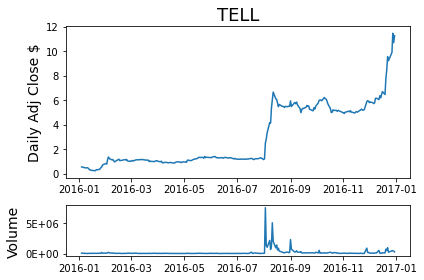

No data fetched for symbol WINS using YahooDailyReader


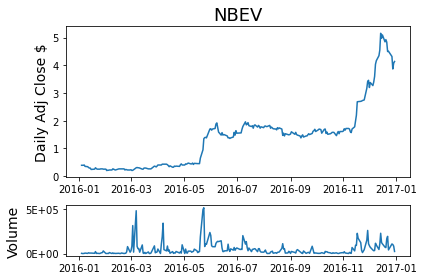

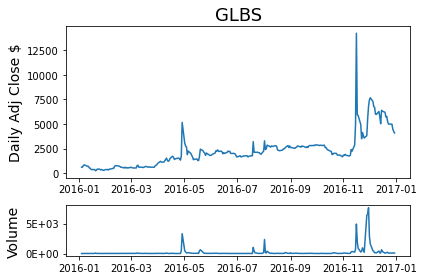

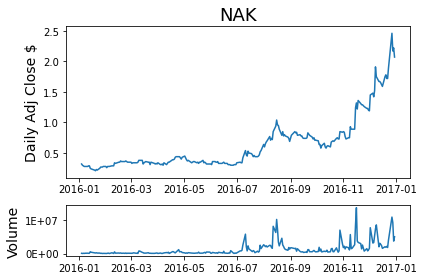

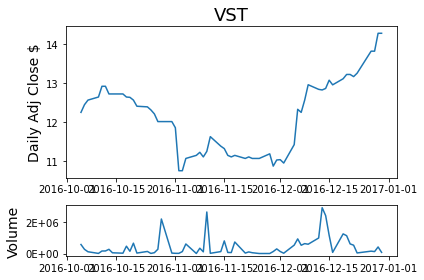

In [163]:
high_gainers_2015 = find_inorganic_stocks(df_2015, 2016, 500)

In [164]:
# we are keeping  NAK and NBEV
high_gainers_2015.remove('NAK')
high_gainers_2015.remove('NBEV')
df_2015.drop(high_gainers_2015, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2016

19 STOCKS with more than 500% gain.



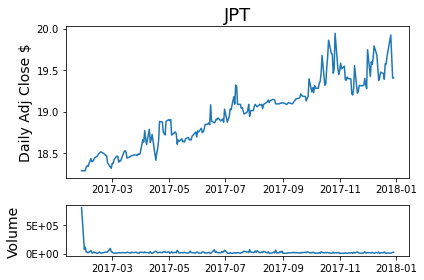

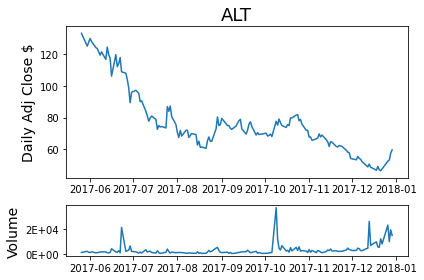

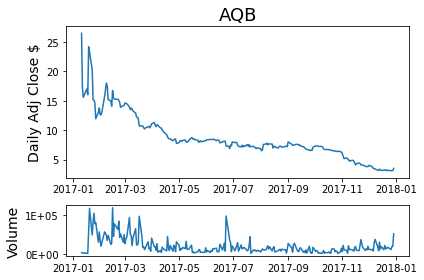

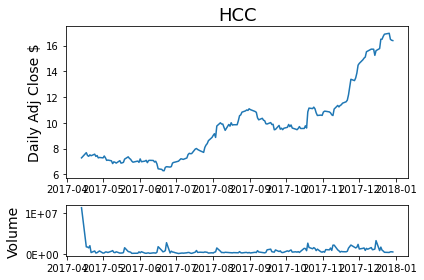

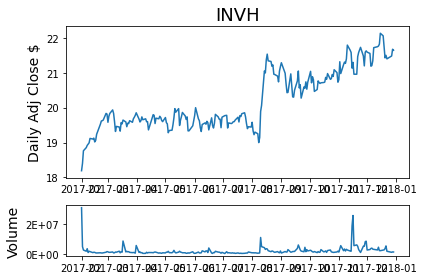

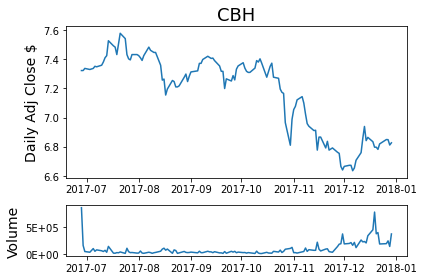

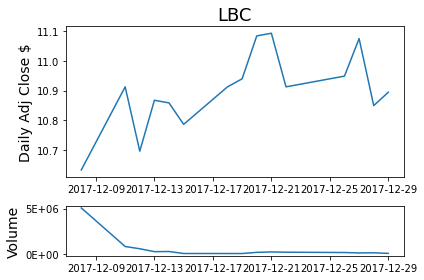

No data fetched for symbol JAG using YahooDailyReader


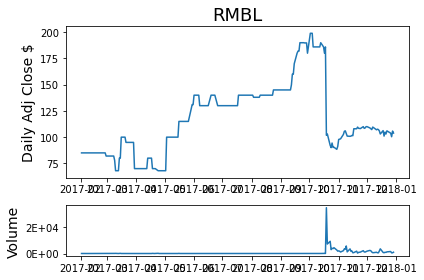

No data fetched for symbol AKCA using YahooDailyReader


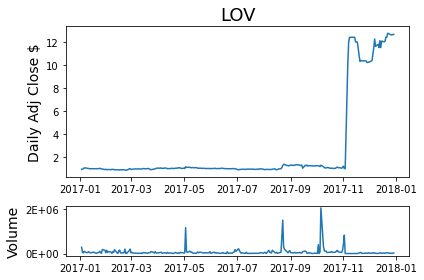

No data fetched for symbol FTNW using YahooDailyReader


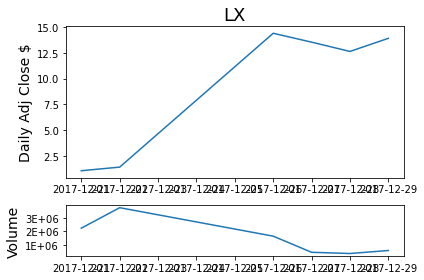

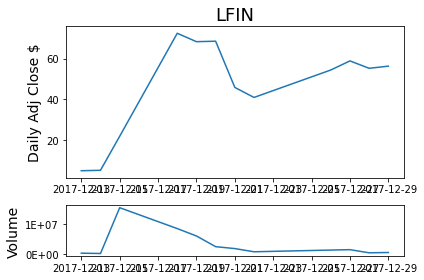

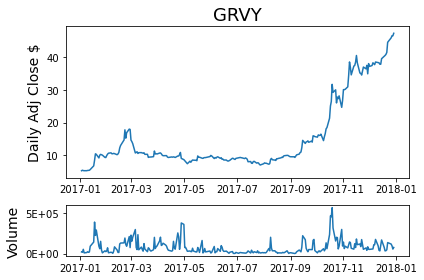

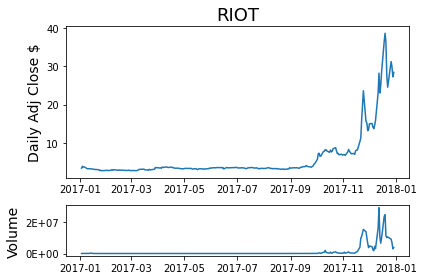

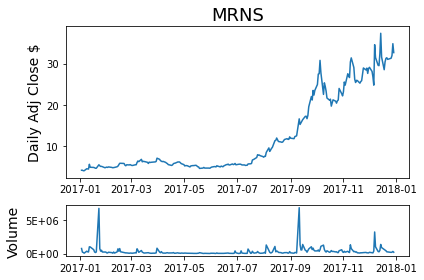

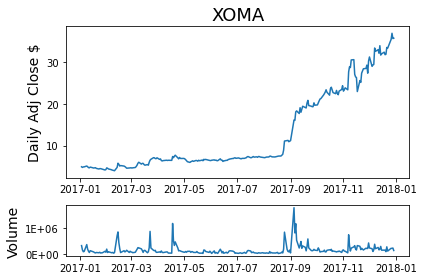

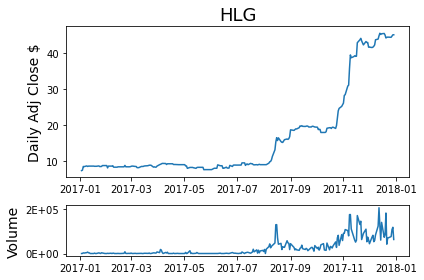

In [165]:
high_gainers_2016 = find_inorganic_stocks(df_2016, 2017, 500)

In [166]:
# we are keeping  HlG and GRVY
high_gainers_2016.remove('HLG')
high_gainers_2016.remove('GRVY')
df_2016.drop(high_gainers_2016, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2017

5 STOCKS with more than 500% gain.

No data fetched for symbol HMI using YahooDailyReader
No data fetched for symbol SIGM using YahooDailyReader


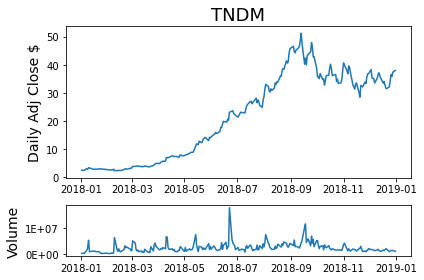

No data fetched for symbol NIHD using YahooDailyReader


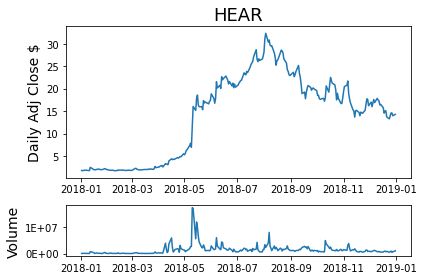

In [167]:
high_gainers_2017 = find_inorganic_stocks(df_2017, 2018, 500)

In [168]:
# we are keeping  HEAR and TNDM
high_gainers_2017.remove('HEAR')
high_gainers_2017.remove('TNDM')
df_2017.drop(high_gainers_2017, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2018

8 STOCKS with more than 500% gain.



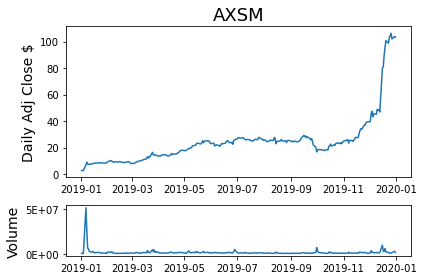

No data fetched for symbol ANFI using YahooDailyReader
No data fetched for symbol SSI using YahooDailyReader


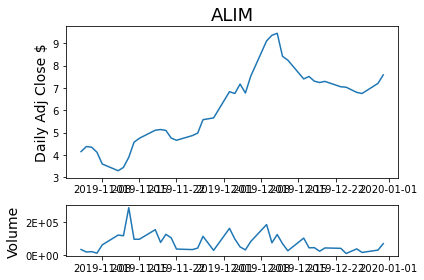

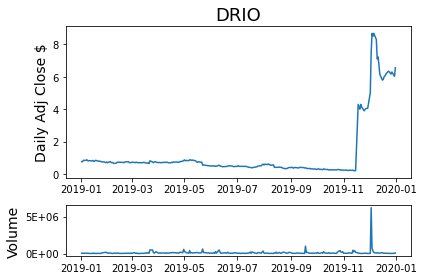

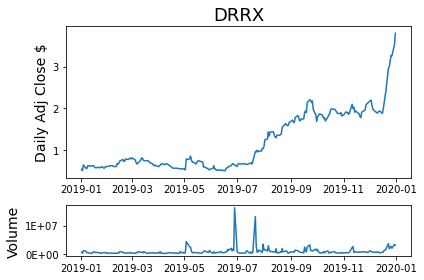

No data fetched for symbol ARQL using YahooDailyReader
No data fetched for symbol HEBT using YahooDailyReader


In [169]:
high_gainers_2018 = find_inorganic_stocks(df_2018, 2019, 500)

In [170]:
# we are keeping  ALIM
high_gainers_2018.remove('ALIM')
df_2018.drop(high_gainers_2018, axis=0, inplace=True)

# 4. Missing values and 0-values

Our dataset contains lots of 0 and missing values. In this chapter we will discuss our approach to remove/replace them. First of all we create a larger dataset by appending all the separate datasets onto each other. Then we will take a closer look at the missing and 0 values and decide how many are allowed to miss in a column in order to keep the column. After that we will get rid of those columns and replace the missing values that are left with an appropriate dummy variable.

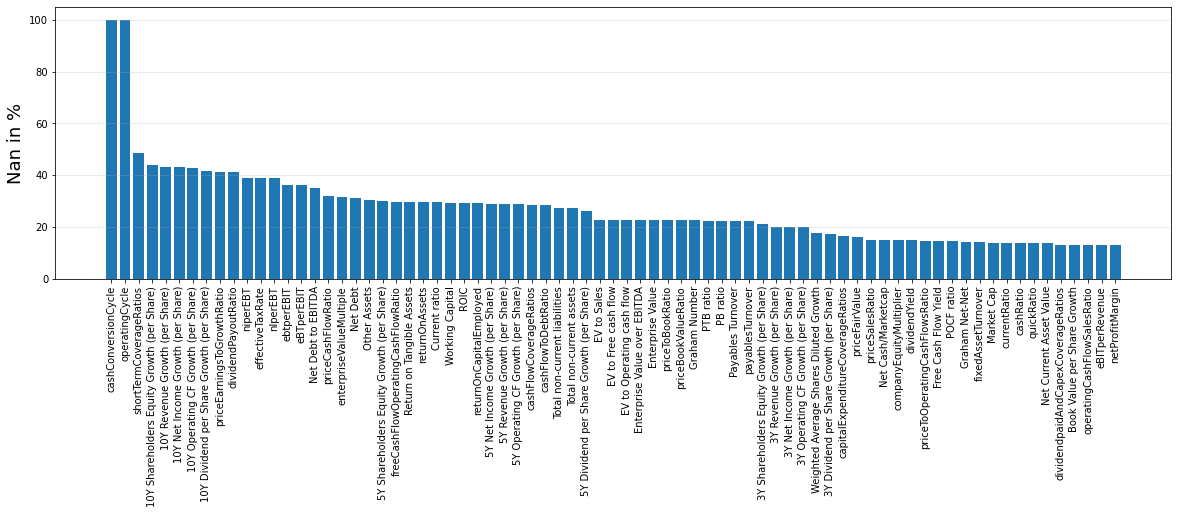

In [171]:
# Find count and percent of nan-values, zero-values
percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(20,5))
plt.bar(np.arange(75), percent_nan.iloc[:75].values.tolist())
plt.xticks(np.arange(75), percent_nan.iloc[:75].index.values.tolist(), rotation='90')
plt.ylabel('Nan in %', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

#drop all of the columns that have more than 20% Nan values
df.drop(percent_nan[percent_nan.values > 20].index.tolist(),axis='columns', inplace=True)

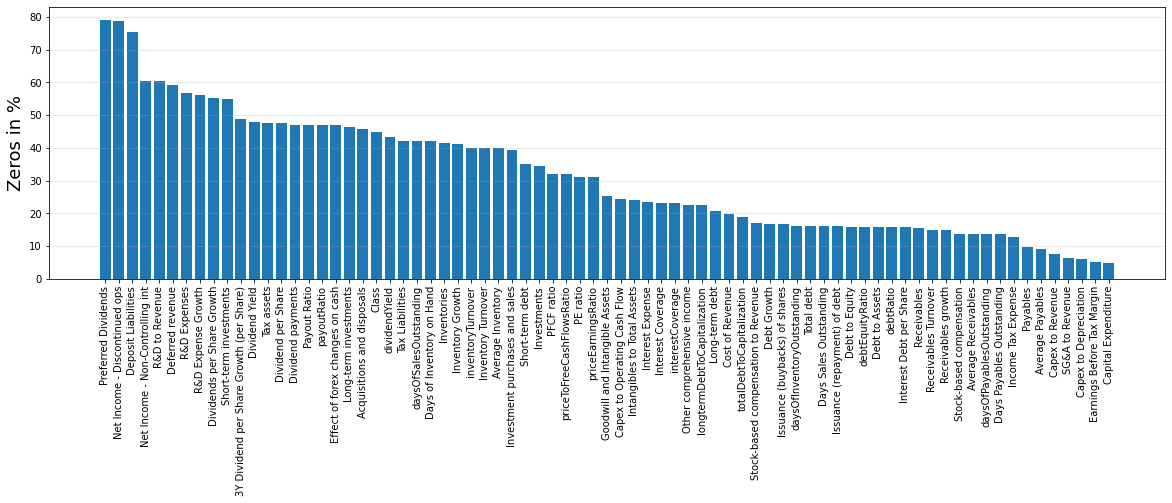

In [172]:
percent_zero = (df.isin([0]).sum()/df.shape[0]*100).sort_values(ascending=False)

plt.figure(figsize=(20,5))
plt.bar(np.arange(75), percent_zero.iloc[:75].values.tolist())
plt.xticks(np.arange(75), percent_zero.iloc[:75].index.values.tolist(), rotation='90')
plt.ylabel('Zeros in %', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

df.drop(percent_zero[percent_zero.values > 20].index.tolist(),axis='columns', inplace=True)

We have quite a lot unwanted variables in some columns. Let's drop all the columns that have more than 20 percent of unwelcomed values.

In [173]:
print(f'NUMBER OF FEATURES: {df.shape[1]}')

NUMBER OF FEATURES: 127


# 5. Outliers/Extreme values

Since outliers pollute our dataset we will go ahead dropping top and bottom 5%

In [174]:
top_quantiles = df.quantile(0.95)
outliers_top = (df > top_quantiles)

low_quantiles = df.quantile(0.05)
outliers_low = (df < low_quantiles)

df = df.mask(outliers_top, top_quantiles, axis=1)
df = df.mask(outliers_low, low_quantiles, axis=1)

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_5451/2162141620.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_top = (df > top_quantiles)
/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_5451/2162141620.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_low = (df < low_quantiles)


# 6. Fill Unappropriate values reasonably

We will be filling the missing values with the sector mean of a given year.

In [181]:
df.replace(0, np.nan, inplace=True)
# Replace nan-values with mean value of column, considering each sector individually.
df_no_sector= df.groupby(['Sector', 'year']).transform(lambda x: x.fillna(x.mean()))

In [176]:
percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
percent_zero = (df.isin([0]).sum()/df.shape[0]*100).sort_values(ascending=False)

In [177]:
percent_zero

Revenue                        0.0
Free Cash Flow per Share       0.0
Income Quality                 0.0
Debt to Assets                 0.0
Debt to Equity                 0.0
                              ... 
Other Liabilities              0.0
Total shareholders equity      0.0
Retained earnings (deficit)    0.0
Total liabilities              0.0
year                           0.0
Length: 127, dtype: float64

In [180]:
df

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Operating Cash Flow growth,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,Sector,PRICE CHANGE [%],year
PG,2.040475e+10,-0.07130,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.382800e+09,6.318000e+08,1.914130e+09,...,-0.06150,-0.06950,-0.0187,0.0359,0.03160,0.1228,-0.17460,Consumer Defensive,-9.323276,2014
VIPS,3.734148e+09,0.90774,2.805625e+09,9.285226e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.753823e+08,3.955957e+07,1.358227e+08,...,0.21340,-0.36260,NaN,NaN,NaN,NaN,0.78378,Consumer Defensive,-25.512193,2014
KR,2.040475e+10,0.01820,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.270000e+09,6.318000e+08,1.519000e+09,...,0.20950,0.39350,0.0618,0.1886,0.32680,0.2738,0.02340,Consumer Defensive,33.118297,2014
RAD,2.040475e+10,0.00530,1.165087e+10,7.323734e+09,3.573876e+09,5.367974e+09,7.372520e+08,2.502180e+08,8.040000e+05,2.494140e+08,...,-0.14340,-0.26910,0.0211,-0.0189,0.19630,-0.0458,-0.00600,Consumer Defensive,2.752291,2014
GIS,1.790960e+10,0.00760,1.153980e+10,6.369800e+09,3.474300e+09,3.412400e+09,2.723871e+09,2.382800e+09,6.318000e+08,1.824400e+09,...,-0.13160,-0.19360,0.0257,0.0215,0.02740,0.1025,-0.02200,Consumer Defensive,12.897715,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV,6.420000e+04,NaN,NaN,NaN,3.755251e+06,6.048059e+06,-3.755251e+06,-1.482451e+07,-1.108025e+06,-1.371648e+07,...,-1.78293,-2.06050,NaN,-0.0508,-0.14090,-0.0152,-0.20680,Real Estate,-62.416396,2018
YTEN,5.560000e+05,-0.31904,NaN,5.560000e+05,5.071000e+06,9.830000e+06,-9.274000e+06,-9.170000e+06,NaN,-9.170000e+06,...,-0.06730,-0.07160,0.3445,-0.2323,-0.65932,NaN,-0.09930,Basic Materials,-62.416396,2018
ZKIN,5.488438e+07,0.22100,3.659379e+07,1.829059e+07,7.020320e+06,8.672953e+06,9.617636e+06,8.416324e+06,1.398210e+06,7.018114e+06,...,-1.78293,-3.30331,0.1605,0.2489,0.40740,-0.0968,0.78378,Basic Materials,-17.834400,2018
ZOM,6.420000e+04,NaN,NaN,NaN,4.521349e+06,1.664863e+07,-1.664863e+07,-1.664769e+07,NaN,-1.664769e+07,...,-0.57160,-0.61970,0.8980,0.1568,-0.22000,NaN,0.14570,Industrials,-62.416396,2018


In [182]:
df_no_sector

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,PRICE CHANGE [%]
PG,2.040475e+10,-0.071300,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.382800e+09,6.318000e+08,1.914130e+09,...,-0.012700,0.034677,-0.06150,-0.06950,-0.018700,0.035900,0.031600,0.122800,-0.17460,-9.323276
VIPS,3.734148e+09,0.907740,2.805625e+09,9.285226e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.753823e+08,3.955957e+07,1.358227e+08,...,0.018400,0.019500,0.21340,-0.36260,0.095544,0.099805,0.052347,0.096758,0.78378,-25.512193
KR,2.040475e+10,0.018200,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.270000e+09,6.318000e+08,1.519000e+09,...,-0.035600,-0.031700,0.20950,0.39350,0.061800,0.188600,0.326800,0.273800,0.02340,33.118297
RAD,2.040475e+10,0.005300,1.165087e+10,7.323734e+09,3.573876e+09,5.367974e+09,7.372520e+08,2.502180e+08,8.040000e+05,2.494140e+08,...,0.069400,0.034677,-0.14340,-0.26910,0.021100,-0.018900,0.196300,-0.045800,-0.00600,2.752291
GIS,1.790960e+10,0.007600,1.153980e+10,6.369800e+09,3.474300e+09,3.412400e+09,2.723871e+09,2.382800e+09,6.318000e+08,1.824400e+09,...,-0.046800,0.034677,-0.13160,-0.19360,0.025700,0.021500,0.027400,0.102500,-0.02200,12.897715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV,6.420000e+04,0.104259,5.352302e+08,5.390162e+08,3.755251e+06,6.048059e+06,-3.755251e+06,-1.482451e+07,-1.108025e+06,-1.371648e+07,...,0.078196,0.093430,-1.78293,-2.06050,0.147173,-0.050800,-0.140900,-0.015200,-0.20680,-62.416396
YTEN,5.560000e+05,-0.319040,2.319553e+09,5.560000e+05,5.071000e+06,9.830000e+06,-9.274000e+06,-9.170000e+06,6.980468e+07,-9.170000e+06,...,0.776780,0.889430,-0.06730,-0.07160,0.344500,-0.232300,-0.659320,0.078856,-0.09930,-62.416396
ZKIN,5.488438e+07,0.221000,3.659379e+07,1.829059e+07,7.020320e+06,8.672953e+06,9.617636e+06,8.416324e+06,1.398210e+06,7.018114e+06,...,0.240700,0.242000,-1.78293,-3.30331,0.160500,0.248900,0.407400,-0.096800,0.78378,-17.834400
ZOM,6.420000e+04,0.119609,1.991121e+09,1.112874e+09,4.521349e+06,1.664863e+07,-1.664863e+07,-1.664769e+07,6.941766e+07,-1.664769e+07,...,0.069100,0.069100,-0.57160,-0.61970,0.898000,0.156800,-0.220000,0.101351,0.14570,-62.416396
